# CML wet/dry detection on 1 CML using CNN architecture of Polz J. [2]

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: All code from [2]__  
github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
thesis: https://doi.org/10.5194/amt-13-3835-2020

In [2]:
import cnn
import xarray as xr               # work with arrays, also possible with pandas
import numpy as np
import torch
import torch.nn as nn
import einops
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [3]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output


#### Load CML data
Import data of 500 CML links from pycomlink with 1min timestep

In [4]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

# Temporarily remove GPS coordinates - might add later with additional cml info for better CNN learning
# https://stackoverflow.com/questions/61003361/drop-coordinate-from-an-xarray-dataarray
cml_set = cml_set.reset_coords(['site_a_latitude','site_b_latitude','site_a_longitude','site_b_longitude'], drop=True)

#### Load Reference data
Reference rain rate data from RADOLAN. With 5 min step

In [5]:
# reference RADOLAN data from pycomlink with 5 min time step
# Path averaged reference RADOLAN data aligned with all 500 CML IDs
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')

In [24]:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cml_set = cml_set.resample(time="5min").max()
cml_ch1 = cml_set.isel(channel_id=0)

xr.combine_nested([cml_ch1,ref_set], concat_dim=["cml_id", "time"])
#xr.combine_by_coords([cml_ch1,ref_set])
#xr.concat([cml_set.isel(channel_id=0),ref_set], dim="time")

# doesnt work
#data_set = xr.concat(cml_list, dim="cml_id")
#data_set
#len(cml_set.rsl)

ValueError: concat_dims has length 2 but the datasets passed are nested in a 1-dimensional structure

In [21]:
len(all.cml_id)

500

## CML data preprocessing
1. choosing cml for training  
2. replacing fault values
3. cnalculating TRSL
4. resampling data  
5. creating dataset of training and reference data + data visualisation
6. Standardising

All from pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb

#### Choose one CML, repair fault data and calculate TRSL

In [11]:
# Choose one cml
k = 0; # index of chosen cml 0-499
my_cml = cml_set.isel(cml_id = k) # https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html
my_ref = ref_set.isel(cml_id = k)

# Check for fault data in TSL, RSL and replace it with NaN https://github.com/jpolz/cml_wd_pytorch/tree/main
my_cml['tsl'] = my_cml.tsl.where(my_cml.tsl != 255.0)
my_cml['rsl'] = my_cml.rsl.where(my_cml.rsl != -99.9)
# Calculate TRSL
my_cml['trsl'] = my_cml.tsl - my_cml.rsl

# show CML dataset
my_cml

<xarray.Dataset> Size: 887kB
Dimensions:       (time: 15840, channel_id: 2)
Coordinates:
  * time          (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T23:59:00
    cml_id        <U3 12B '0'
    length        float64 8B ...
  * channel_id    (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency     (channel_id) float64 16B ...
    polarization  (channel_id) <U1 8B ...
Data variables:
    rsl           (channel_id, time) float64 253kB -47.0 -47.0 ... -46.7 -47.0
    tsl           (channel_id, time) float64 253kB 13.0 12.0 12.0 ... 10.0 10.0
    trsl          (channel_id, time) float64 253kB 60.0 59.0 58.7 ... 56.7 57.0

#### Resample CML data to 5 min step 

In [12]:
# maybe try to calculate rate of resampling from cml and ref data
my_cml = my_cml.resample(time="5min").mean() # from Pycomlink
len(my_cml.time)

3168

#### Align to a dataset with Reference RADOLAN data and calculate boolean Wet/dry Reference flag

In [17]:
my_data_set = my_cml.assign(my_ref)
# From reference rain rate derivate binary reference Wet/Dry signal
my_data_set['ref_wet_dry'] = my_ref.rainfall_amount.where(my_ref.rainfall_amount == 0, True) # ChatGPT
# my_data_set

#### Plot whole dataset of the one chosen cml 

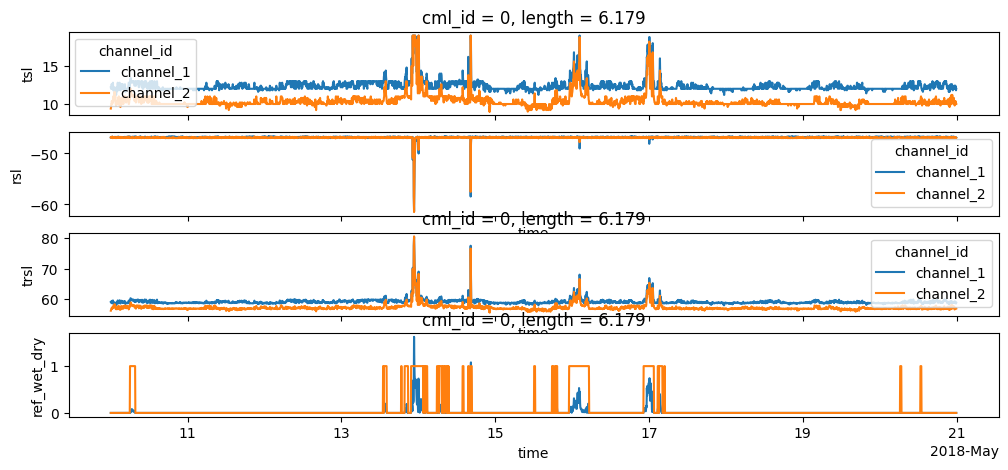

In [19]:
# Plot all input cml and reference data
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12,5))
my_data_set.tsl.plot.line(x='time', ax=axs[0])
my_data_set.rsl.plot.line(x='time', ax=axs[1])
my_data_set.trsl.plot.line(x='time', ax=axs[2])
my_data_set.rainfall_amount.plot.line(x='time', ax=axs[3])
my_data_set.ref_wet_dry.plot.line(x='time', ax=axs[3])

axs[0].set_xlabel('')
axs[1].set_title('');

#### Data visualisation

In [23]:
np.histogram(my_data_set.tsl)

(array([ 258, 2471,  499, 2598,  353,   55,   32,   24,   11,   35]),
 array([ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]))

#### <span style="color:red">TODO: </span>Standardising
Subtracting the median of all available data from the preceding 72h from each time step [2] 


#### <span style="color:red">TODO: </span>Training/Testing/validation data splitting

#### <span style="color:red">TODO: </span>We need to make Wet/Dry periods 50:50 for the training

In [22]:
last_hour = range(-1,-60,-1)
my_data_set['wet_radar'] = my_data_set.rainfall_amount.isel(timestep=last_hour).sum(dim='timestep')>0.1

ValueError: Dimensions {'timestep'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'time': 3168})

## _________________

In [15]:
ds['tl'] = ds.tl.transpose('sample_number', 'channel_id', 'timestep')

NameError: name 'ds' is not defined

In [ ]:
ds

In [ ]:
batchsize = 10
working_size = int(len(ds.sample_number)*0.8/batchsize)* batchsize

In [ ]:
working_size

In [ ]:
tl, wr = shuffle(ds.tl.values, ds.wet_radar.values)

data = tl[:working_size]
data_test = tl[working_size:]
data_out = wr[:working_size]
data_test_out = wr[working_size:]

In [ ]:
np.histogram(data_test_out)

bsp zum "abrunden" auf ganze batch size
`data = data[:int(len(data/batch_size))*batch_size]`

In [ ]:

### data as Tensor
data = torch.Tensor(data)
data_test = torch.Tensor(data_test)

data_out = torch.Tensor(data_out)
data_test_out = torch.Tensor(data_test_out)


In [ ]:

### prepare data
dataset = torch.utils.data.TensorDataset(data, data_out)
testset = torch.utils.data.TensorDataset(data_test, data_test_out)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)


In [ ]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
resume = 0

In [ ]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

In [ ]:
for epoch in range(resume, epochs):
    # training
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        optimizer.zero_grad()
        pred = model(inputs)
        pred = nn.Flatten(0,1)(pred)
        loss = nn.BCELoss()(pred, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))
    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

In [ ]:
for inputs, targets in tqdm(trainloader):
    print(model(inputs))
    break

In [ ]:
### accuracy score, confusion matrix and Matthews correlation coefficient (MCC)
def eval_model(test_dataloader, model):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            pred = model(inputs)
            pred = pred.detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            pred = pred.round()
    
            predictions.append(pred)
            actuals.append(actual)
    predictions, actuals = np.ravel(np.vstack(predictions)), np.ravel(np.vstack(actuals))
    acc = skl.accuracy_score(actuals, predictions)
    conf_mat = skl.confusion_matrix(actual, pred, labels=[0,1], normalize='all')
    matt_cor = skl.matthews_corrcoef(actual, pred)
    return acc, conf_mat, matt_cor

In [ ]:
eval_model(testloader, model)